# Preliminary Filtering of the Dictionary Sequencing Data

**Author:** Michelle Franc Ragsac (mragsac@eng.ucsd.edu) 

### Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('mode.chained_assignment', None) # disable the setting with copy parning

---

## Import the FLASH-Combined, Collapsed Datasets 

In [2]:
df1 = pd.read_csv('../03_collapse/SN_720bc_Rep_1.extendedFrags_collapsed.txt',header=None,sep='\t')
df2 = pd.read_csv('../03_collapse/SN_720bc_Rep_2.extendedFrags_collapsed.txt',header=None,sep='\t')

In [3]:
# Rename the columns for both dataframes
df1.columns = ['Raw_Sequence','Raw_Counts']
df2.columns = ['Raw_Sequence','Raw_Counts']

# Sort the values for both dataframes
print(f"Replicate 1: There are {df1.shape[0]} unique sequences in the dictionary ({df1['Raw_Counts'].sum()} reads)")
print(f"Replicate 2: There are {df2.shape[0]} unique sequences in the dictionary ({df2['Raw_Counts'].sum()} reads)")

Replicate 1: There are 94684 unique sequences in the dictionary (2979081 reads)
Replicate 2: There are 95636 unique sequences in the dictionary (3093925 reads)


---

## Combine Both Replicates into a Single Dataframe, `df`

In [4]:
# Combine both of the datasets on the union of their "Raw_Sequence"s 
df = pd.merge(df1,df2,on='Raw_Sequence',how='outer').fillna(0)
df.columns = ['Raw_Sequence','Raw_Counts_Rep1','Raw_Counts_Rep2']

df.head() # preview the dataframe

,Raw_Sequence,Raw_Counts_Rep1,Raw_Counts_Rep2
0,CAACGGGACCACAGCCGGCTAAAGCTTCGTACTAGCTCAATTGGGT...,12498.0,12964.0
1,AAGCCAGGCGCAAAACAGCGAATGTGAAACACTAGCTCGACTTTCT...,1819.0,1802.0
2,CGGGAAACAAGCAAATGTACGACAATATGAACTAGCTCGATTAATC...,2790.0,2740.0
3,ATATTGAATACGTAGACGACATAGATGCTCACTAGCTCATAGTTTA...,5508.0,5925.0
4,ATGGCATGAAATGGGCGACCAGAGACACTCACTAGCTCGCACCTTA...,3932.0,3755.0


In [5]:
# Determine the Pearson Correlation between the two datasets
df.corr() 

,Raw_Counts_Rep1,Raw_Counts_Rep2
Raw_Counts_Rep1,1.000000,0.999451
Raw_Counts_Rep2,0.999451,1.000000


Since the Pearson correlation between Replicate 1 and Replicate 2 for our dictionary sequencing is quite high (r = 0.999451), we will continue with combining the counts.

In [6]:
# Add together the raw counts between Replicate 1 and Replicate 2
df['Raw_Counts'] = df['Raw_Counts_Rep1'] + df['Raw_Counts_Rep2']

df.head() # preview the dataframe

,Raw_Sequence,Raw_Counts_Rep1,Raw_Counts_Rep2,Raw_Counts
0,CAACGGGACCACAGCCGGCTAAAGCTTCGTACTAGCTCAATTGGGT...,12498.0,12964.0,25462.0
1,AAGCCAGGCGCAAAACAGCGAATGTGAAACACTAGCTCGACTTTCT...,1819.0,1802.0,3621.0
2,CGGGAAACAAGCAAATGTACGACAATATGAACTAGCTCGATTAATC...,2790.0,2740.0,5530.0
3,ATATTGAATACGTAGACGACATAGATGCTCACTAGCTCATAGTTTA...,5508.0,5925.0,11433.0
4,ATGGCATGAAATGGGCGACCAGAGACACTCACTAGCTCGCACCTTA...,3932.0,3755.0,7687.0


In [7]:
# Output the raw, combined results
df[['Raw_Sequence','Raw_Counts']].to_csv('outputs/01_20210808_MR_SN-720bc_Preliminary-Filtering-Sequencing-Data_combined-output.tsv',
                                         sep='\t',index=False,header=False)

---

## Filter Out Reads with N's Present and Reads Missing a Linker Sequence

In [8]:
print(f"Before Filtering: There are {df.shape[0]} unique sequences in the dictionary ({df['Raw_Counts'].sum()} reads)")

Before Filtering: There are 145945 unique sequences in the dictionary (6073006.0 reads)


### Identify and Filter Out Sequences with N's Present

In [9]:
df['hasN'] = df.apply(lambda r: True if 'N' in r['Raw_Sequence'] else False, axis=1)
print(f"There are {df['hasN'].sum()} sequences with an N present, {df.shape[0] - df['hasN'].sum()} sequences with no N present\n")

df_filtN = df.loc[df['hasN'] == False]
print(f"Before Filtering: There are {df.shape[0]} unique sequences in the dictionary ({df['Raw_Counts'].sum()} reads)")
print(f"-1- Removing N's: There are {df_filtN.shape[0]} unique sequences in the dictionary ({df_filtN['Raw_Counts'].sum()} reads)")

There are 9686 sequences with an N present, 136259 sequences with no N present

Before Filtering: There are 145945 unique sequences in the dictionary (6073006.0 reads)
-1- Removing N's: There are 136259 unique sequences in the dictionary (5982124.0 reads)


### Identify and Filter Out Sequences Missing a Linker 

In [10]:
# First, define the linker information for sequences that run 
# in the proper forward direction (R1 to R2)

linker_sequence = "ACTAGCTC"
linker_location = 31 # defines precise location in the design
linker_window = 10 # defines the window to which to look for the linker

In [11]:
def hamming_distance(seq1,seq2):
    """Helper Method:
    Determines the Hamming Distance (# mismatches) between two sequences
    """
    return(sum([1 for i,j in zip(seq1,seq2) if i != j]))

def find_linker(sequence,hamming_threshold=2):
    """Given a sequence, split the sequence according to the
    linker sequence that is present (with mismatches allowed according
    to the hamming threshold)
    """
    # Attempt looking for an exact match of the linker, 
    # then splitting the sequence according to this exact match
    exact_split = sequence.split(linker_sequence)
    if len(exact_split) == 2:
        return(exact_split)
    
    # If we can't find an exact match, search for the linker sequence
    # and split with hamming distance of less than some threshold
    potential_linker_sequences = [
        sequence[i:i+len(linker_sequence)] for i in range(
            linker_location-linker_window,linker_location+linker_window)]
    
    for subseq in potential_linker_sequences:
        if hamming_distance(subseq,linker_sequence) <= hamming_threshold:
            approximate_split = sequence.split(subseq)
            return(approximate_split)
    
    # If we can't find the linker sequence, return the original sequence
    return([sequence])

In [12]:
# Split the sequence according to whether or not the exact linker sequence is present around the 31st base
df_filtN['Split_Sequence'] = df_filtN.apply(lambda r: find_linker(r['Raw_Sequence']), axis=1)

# From the linker sequence, determine the length of the barcode and number of splits we've had
df_filtN['Barcode_Length'] = df_filtN.apply(lambda r: len(r['Split_Sequence'][0]), axis=1) # assume barcode before first split
df_filtN['Number_Of_Splits'] = df_filtN.apply(lambda r: len(r['Split_Sequence']), axis=1)

### Plot the Distribution of Barcode Lengths and Number of Linkers Present in a Sequence Before Filtering

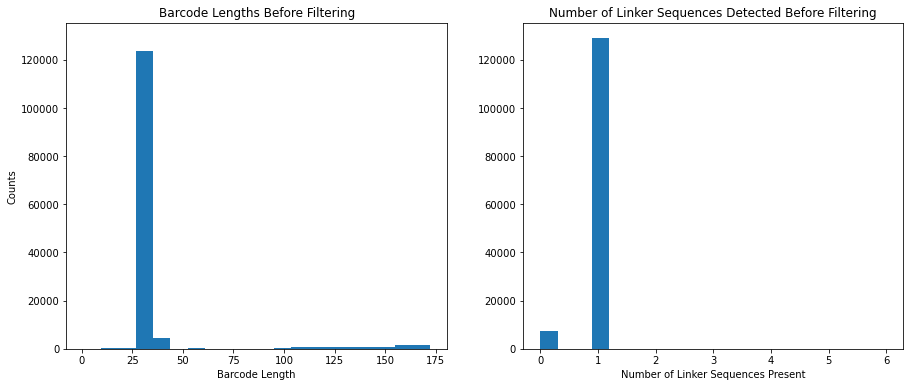

In [13]:
plt.figure(figsize=(15,6));

ax1 = plt.subplot(121);
plt.hist(df_filtN['Barcode_Length'],bins=20);
plt.xlabel('Barcode Length');
plt.ylabel('Counts');
plt.title('Barcode Lengths Before Filtering');

plt.subplot(122,sharey=ax1);
plt.hist(df_filtN['Number_Of_Splits']-1,bins=20);
plt.xlabel('Number of Linker Sequences Present');
# plt.ylabel('Counts');
plt.title('Number of Linker Sequences Detected Before Filtering');

### Filter Out Reads Missing a Linker and Reads with an Improper Barcode Length

We are expecting our barcodes to be 29-30 bp in length.

In [14]:
df_filtN_filtL = df_filtN.loc[df_filtN['Number_Of_Splits'] == 2]
df_filtN_filtL_filtB = df_filtN_filtL.loc[(df_filtN_filtL['Barcode_Length'] == 29) | (df_filtN_filtL['Barcode_Length'] == 30)]

print(f"Before Filtering: There are {df.shape[0]} unique sequences in the dictionary ({df['Raw_Counts'].sum()} reads)")
print(f"-1- Removing N's: There are {df_filtN.shape[0]} unique sequences in the dictionary ({df_filtN['Raw_Counts'].sum()} reads)")
print(f"-2- Has 1 Linker: There are {df_filtN_filtL.shape[0]} unique sequences in the dictionary ({df_filtN_filtL['Raw_Counts'].sum()} reads)")
print(f"-3- Has 29-30 BC: There are {df_filtN_filtL_filtB.shape[0]} unique sequences in the dictionary ({df_filtN_filtL_filtB['Raw_Counts'].sum()} reads)")

Before Filtering: There are 145945 unique sequences in the dictionary (6073006.0 reads)
-1- Removing N's: There are 136259 unique sequences in the dictionary (5982124.0 reads)
-2- Has 1 Linker: There are 128993 unique sequences in the dictionary (5965228.0 reads)
-3- Has 29-30 BC: There are 121346 unique sequences in the dictionary (5863907.0 reads)


In [15]:
df_filt = df_filtN_filtL_filtB # make the naming a lot easier 

---

## Determine the Barcode and Enhancer Sequences in our Dictionary

With the way that we've designed the dictionary, the barcode is the first sequence within our read. Afterwards, the enhancer is the reverse complement of the second portion of the sequence after the linker.

In [16]:
df_filt['Barcode'] = df_filt.apply(lambda r: r['Split_Sequence'][0], axis=1)
df_filt['Enhancer-Read'] = df_filt.apply(lambda r: r['Split_Sequence'][1], axis=1)

### Convert the Enhancer Sequence in the Read to its Reverse Complement Sequence

In [17]:
def reverse_complement(sequence):
    base_pairs = {'A':'T','T':'A','C':'G','G':'C','N':'N'}
    return(''.join([base_pairs[i] for i in sequence])[::-1])

In [18]:
df_filt['Enhancer'] = df_filt.apply(lambda r: reverse_complement(r['Enhancer-Read']), axis=1)

df_filt.head() # preview the dataframe

,Raw_Sequence,Raw_Counts_Rep1,Raw_Counts_Rep2,Raw_Counts,hasN,Split_Sequence,Barcode_Length,Number_Of_Splits,Barcode,Enhancer-Read,Enhancer
0,CAACGGGACCACAGCCGGCTAAAGCTTCGTACTAGCTCAATTGGGT...,12498.0,12964.0,25462.0,False,"[CAACGGGACCACAGCCGGCTAAAGCTTCGT, AATTGGGTTCAAA...",30,2,CAACGGGACCACAGCCGGCTAAAGCTTCGT,AATTGGGTTCAAACAGTATCCCATTTTACCCCGCAGTACTATATTC...,CAGTTGCAAAGTAAGACATAGGAATATAGTACTGCGGGGTAAAATG...
1,AAGCCAGGCGCAAAACAGCGAATGTGAAACACTAGCTCGACTTTCT...,1819.0,1802.0,3621.0,False,"[AAGCCAGGCGCAAAACAGCGAATGTGAAAC, GACTTTCTCCCAA...",30,2,AAGCCAGGCGCAAAACAGCGAATGTGAAAC,GACTTTCTCCCAAGCACGCGGCTATCCAGGCCGCAGTGTGTGATCC...,GGAGTTCAGACGAGGAGAAACCAGCCTTCCGAAAGCACGCAGCGTG...
2,CGGGAAACAAGCAAATGTACGACAATATGAACTAGCTCGATTAATC...,2790.0,2740.0,5530.0,False,"[CGGGAAACAAGCAAATGTACGACAATATGA, GATTAATCTGGGG...",30,2,CGGGAAACAAGCAAATGTACGACAATATGA,GATTAATCTGGGGAATAATGGAATATAATACTGCGGGGTAAAATGG...,CATTATTTGCTAACGGTATCCCATTTTACCCCGCAGTATTATATTC...
3,ATATTGAATACGTAGACGACATAGATGCTCACTAGCTCATAGTTTA...,5508.0,5925.0,11433.0,False,"[ATATTGAATACGTAGACGACATAGATGCTC, ATAGTTTATGTCG...",30,2,ATATTGAATACGTAGACGACATAGATGCTC,ATAGTTTATGTCGTGAATAGGGATCCATGCCCGCAGTTGGCTCATC...,CTTTTGCAGATATTAATACTGGATGAGCCAACTGCGGGCATGGATC...
4,ATGGCATGAAATGGGCGACCAGAGACACTCACTAGCTCGCACCTTA...,3932.0,3755.0,7687.0,False,"[ATGGCATGAAATGGGCGACCAGAGACACTC, GCACCTTATCAAT...",30,2,ATGGCATGAAATGGGCGACCAGAGACACTC,GCACCTTATCAATGGATGCTACCAATGTATCACAGCGGTGAACTCT...,GTTCAGGATTGTCACTACAGCTAGAGTTCACCGCTGTGATACATTG...


---

## Filter Out Sequences with Low Read Counts

### Plot the Distribution of Read Counts in our Present Dataframe

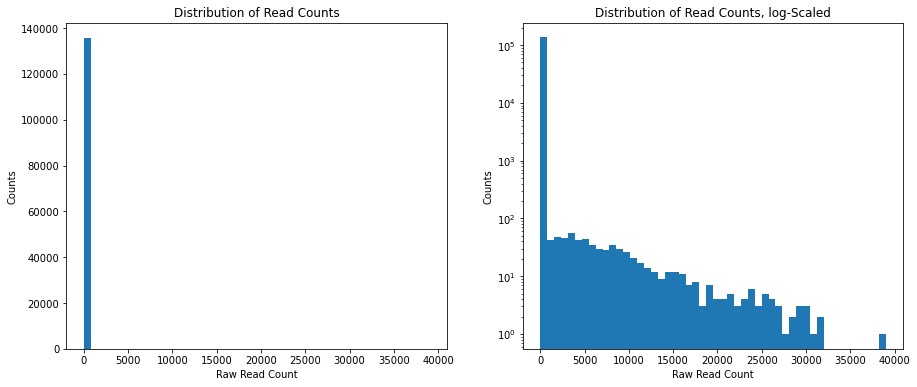

In [19]:
plt.figure(figsize=(15,6));

plt.subplot(121);
plt.hist(df_filtN['Raw_Counts'],bins=50);
plt.xlabel('Raw Read Count');
plt.ylabel('Counts');
plt.title('Distribution of Read Counts');

plt.subplot(122);
plt.hist(df_filtN['Raw_Counts'],bins=50);
plt.xlabel('Raw Read Count');
plt.ylabel('Counts');
plt.yscale('log')
plt.title('Distribution of Read Counts, log-Scaled');

### Filter Out Sequences with Low Read Counts

In [20]:
df_filt_filtRC = df_filt.loc[df_filt['Raw_Counts'] >= 150]

print(f"Before Filtering: There are {df.shape[0]} unique sequences in the dictionary ({df['Raw_Counts'].sum()} reads)")
print(f"-1- Removing N's: There are {df_filtN.shape[0]} unique sequences in the dictionary ({df_filtN['Raw_Counts'].sum()} reads)")
print(f"-2- Has 1 Linker: There are {df_filtN_filtL.shape[0]} unique sequences in the dictionary ({df_filtN_filtL['Raw_Counts'].sum()} reads)")
print(f"-3- Has 29-30 BC: There are {df_filtN_filtL_filtB.shape[0]} unique sequences in the dictionary ({df_filtN_filtL_filtB['Raw_Counts'].sum()} reads)")
print(f"-4- Has >=150 RC: There are {df_filt_filtRC.shape[0]} unique sequences in the dictionary    ({df_filt_filtRC['Raw_Counts'].sum()} reads)")

Before Filtering: There are 145945 unique sequences in the dictionary (6073006.0 reads)
-1- Removing N's: There are 136259 unique sequences in the dictionary (5982124.0 reads)
-2- Has 1 Linker: There are 128993 unique sequences in the dictionary (5965228.0 reads)
-3- Has 29-30 BC: There are 121346 unique sequences in the dictionary (5863907.0 reads)
-4- Has >=150 RC: There are 699 unique sequences in the dictionary    (5410613.0 reads)


This final number of 699 sequences after preliminary filtering is fine because we are expecting our dictionary only have 130 things total. Within the next notebook, we can compare directly to the 130 sequences that we inputted to see if they appear within the dictionary.

### Plot the Distribution of Read Counts in our Dataframe After Filtering

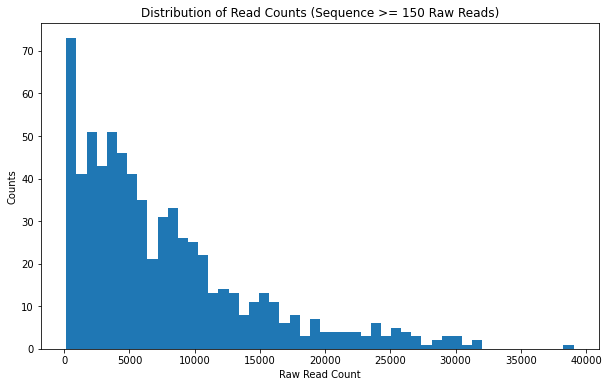

In [21]:
plt.figure(figsize=(10,6));

plt.hist(df_filt_filtRC['Raw_Counts'],bins=50);
plt.xlabel('Raw Read Count');
plt.ylabel('Counts');
plt.title('Distribution of Read Counts (Sequence >= 150 Raw Reads)');

---

## Evaluate the Enhancer Sequences for Proper Length to Include in the Library

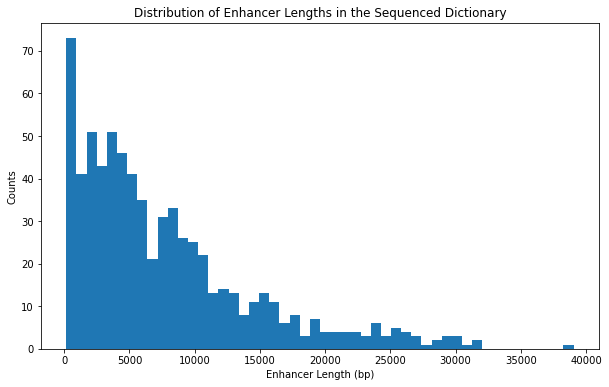

In [22]:
# Calculate the length of each enhancer within our sequencing data
df_filt_filtRC['Enhancer_Length'] = df_filt_filtRC.apply(lambda r: len(r['Enhancer']), axis=1)

# Show the distribution of lengths for each enhancer
plt.figure(figsize=(10,6));
plt.hist(df_filt_filtRC['Raw_Counts'],bins=50);
plt.xlabel('Enhancer Length (bp)');
plt.ylabel('Counts');
plt.title('Distribution of Enhancer Lengths in the Sequenced Dictionary');

---

## Export the Filtered Library

In [23]:
# Output the raw, combined results
df_filt_filtRC.to_csv('outputs/01_MR_SN-720bc_Preliminary-Filtering-Sequencing-Data_filtered-output.tsv',sep='\t',index=False)
pickle.dump(df_filt_filtRC,open('outputs/01_MR_SN-720bc_Preliminary-Filtering-Sequencing-Data_filtered-output.pickle','wb'))
print("Done!")

Done!
